# Non-Markovianity estimations
## (for spin-boson system using Breuer measure approximation)  

In [1]:
using LinearAlgebra
using Combinatorics
using Plots
using HDF5

using QuantumOptics
basis = NLevelBasis(2)

include("LiPoSID.jl")

Main.LiPoSID

Trace distance:

$D(\rho_1, \rho_2) = \frac{1}{2} \operatorname{Tr}|\rho_1 - \rho_2|$,

where $|A| = \sqrt{A^\dagger A}$

Non-Markovianity:

(H.-P. Breuer, E.-M. Laine, J. Piilo, "Measure for the Degree of Non-Markovian Behavior of Quantum Processes in Open Systems," Physical Review Letters, 2009.)

$\sigma = \frac{dD}{dt}$

$ \mathcal{N} = \max_{\rho_1(0), \rho_2(0)}{\int_{\sigma>0}{\sigma dt}} $

In [2]:
#Test trace distance function

ρ₁ = [1 im
      -im 0]

ρ₂ = [.99 im
      -im .01]      

LiPoSID.TrDist(ρ₁, ρ₂)

0.010000000000000005

In [3]:
function read_hdf5_H_C(file_path::String, group_name::String)
    # Open the HDF5 file in read-only mode
    h5file = h5open(file_path, "r") do file
        # Check if the group exists
        if haskey(file, group_name)
            group = file[group_name]
            
            # Check if datasets "H" and "C" exist in the group
            if haskey(group, "H") && haskey(group, "C")
                H = read(group["H"])    # Read dataset "H"
                C = read(group["C"])    # Read dataset "C"
                
                # Return both datasets
                return H, C
            else
                error("Datasets 'H' or 'C' not found in the group ", group_name)
            end
        else
            error("Group ", group_name, " not found in the file.")
        end
    end
end

function read_hdf5_H_J(file_path::String, group_name::String)
    # Open the HDF5 file in read-only mode
    h5file = h5open(file_path, "r") do file
        # Check if the group exists
        if haskey(file, group_name)
            group = file[group_name]
            
            # Check if datasets "H" and "C" exist in the group
            if haskey(group, "H") && haskey(group, "J1")
                H = read(group["H"])    # Read dataset "H"
                J1 = read(group["J1"])    # Read dataset "L1"
                J2 = read(group["J2"])    # Read dataset "L2"
                J3 = read(group["J3"])    # Read dataset "L3"
                J4 = read(group["J4"])    # Read dataset "L4"
                
                # Return both datasets
                return H, [J1, J2, J3, J4]
            else
                error("Datasets 'H' or 'J1' not found in the group ", group_name)
            end
        else
            error("Group ", group_name, " not found in the file.")
        end
    end
end

read_hdf5_H_J (generic function with 1 method)

In [4]:
σˣ = [ 0 1 
       1 0 ]

σʸ = [ 0.   im*1
      -im*1 0    ]

σᶻ = [ 1.  0
       0  -1 ] 

fᴷ₁ = σˣ/2; fᴷ₂ = σʸ/2; fᴷ₃ = σᶻ/2

@assert tr(σˣ/2*σʸ/2) == tr(σˣ/2*σᶻ/2) ==  tr(σʸ/2*σᶻ/2) ≈ 0
@assert tr(σˣ/2*σˣ/2) == tr(σʸ/2*σʸ/2) == tr(σᶻ/2*σᶻ/2) ≈ 1/2

fᴷᴼᴺᴮ = [fᴷ₁, fᴷ₂, fᴷ₃]

3-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im 0.5 + 0.0im; 0.5 + 0.0im 0.0 + 0.0im]
 [0.0 + 0.0im 0.0 + 0.5im; 0.0 - 0.5im 0.0 + 0.0im]
 [0.5 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -0.5 + 0.0im]

In [5]:
function simulate_lindblad_timevolution(H, effective_Lindblad_ops, state, γᵢ)

    tₛ, ρₛ = LiPoSID.read_timeevolution(evol_data_file_name, state, γᵢ)
    ρₛ = convert(Vector{Matrix{ComplexF64}}, ρₛ)
    #bᵗˢᵗ = LiPoSID.bloch(ρₛ)
    ρᵗˢᵗ = [DenseOperator(basis,Hermitian(ρₜ)) for ρₜ in ρₛ]
    tᵗˢᵗ = convert(Vector{Float64}, tₛ)

    ρₒ = DenseOperator(basis, ρₛ[1])
    dt = tᵗˢᵗ[2] - tᵗˢᵗ[1]
    tᵉⁿᵈ = tᵗˢᵗ[end]

    tout, ρ_t_kossak = timeevolution.master(convert.(Float64, tᵗˢᵗ), ρₒ, DenseOperator(basis, H), effective_Lindblad_ops)
    ρˢⁱᵈ  = [ρₜ.data for ρₜ in ρ_t_kossak]

end

simulate_lindblad_timevolution (generic function with 1 method)

In [6]:
function NonMarkovianity_Kossak(states, γᵢ)
    N=[]

    H, C = read_hdf5_H_C("KOSSAK_CONSTR_TSSOS_treshold_1e-15_FROB_QO_2024-Sep-06_at_11-57.h5", γᵢ)
    effective_Lindblad = LiPoSID.get_lindblad_operators(convert.(ComplexF64, C), fᴷᴼᴺᴮ)
    effective_Lindblad_ops = [DenseOperator(basis,j) for j in effective_Lindblad]

    for (i,j)  in combinations(1:length(states), 2)
        ρs₁ = simulate_lindblad_timevolution(H, effective_Lindblad_ops, states[i], γᵢ)
        ρs₂ = simulate_lindblad_timevolution(H, effective_Lindblad_ops, states[j], γᵢ)

        # Calculate trace distance for each pair of states
        trace_dists = [LiPoSID.TrDist(ρ₁, ρ₂) for (ρ₁, ρ₂) in zip(ρs₁, ρs₂)]
        
        # Compute differences between consecutive trace distances
        dD = diff(trace_dists)

        # Only consider positive differences
        append!(N, sum(dD[dD.>0]))
    end
    maximum(N)
end  

function NonMarkovianity_Lindblad(states, γᵢ)
    N=[]

    H, J = read_hdf5_H_J("LINDBLAD4_CONSTR_TSSOS_treshold_1e-9_FROB_QO_2024-Sep-06_at_16-19.h5", γᵢ)
    
    effective_Lindblad_ops = [DenseOperator(basis,j) for j in J]

    for (i,j)  in combinations(1:length(states), 2)
        ρs₁ = simulate_lindblad_timevolution(H, effective_Lindblad_ops, states[i], γᵢ)
        ρs₂ = simulate_lindblad_timevolution(H, effective_Lindblad_ops, states[j], γᵢ)

        # Calculate trace distance for each pair of states
        trace_dists = [LiPoSID.TrDist(ρ₁, ρ₂) for (ρ₁, ρ₂) in zip(ρs₁, ρs₂)]
        
        # Compute differences between consecutive trace distances
        dD = diff(trace_dists)

        # Only consider positive differences
        append!(N, sum(dD[dD.>0]))
    end
    maximum(N)
end  

NonMarkovianity_Lindblad (generic function with 1 method)

In [15]:
evol_data_file_name = "DATA/ALL_GAMMAS_B4_D10.h5"

"DATA/ALL_GAMMAS_B4_D10.h5"

In [16]:
dodeca_10_states = ["D"*string(n) for n=1:10];
basis_states = ["B"*string(n) for n=1:4];

all_states = vcat(basis_states, dodeca_10_states);

In [17]:
γ = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133", "79.477", "251.33"];

In [18]:
N_K = [NonMarkovianity_Kossak(all_states, γᵢ) for γᵢ in γ]
N_K'

1×8 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [19]:
N_L = [NonMarkovianity_Lindblad(all_states, γᵢ) for γᵢ in γ]
N_L'

1×8 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

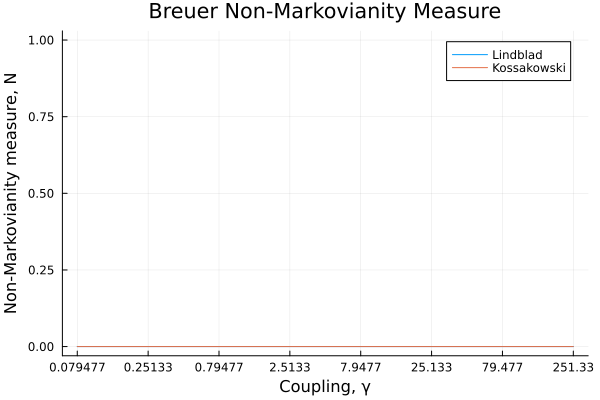

In [20]:
# Plot the data
plot(N_L, xticks=(1:length(γ), γ), label="Lindblad")
plot!(N_K, xticks=(1:length(γ), γ), label="Kossakowski")

# Set labels
xlabel!("Coupling, γ")
ylabel!("Non-Markovianity measure, N")

# Optionally set a title
title!("Breuer Non-Markovianity Measure")

# Save the figure to a file
#savefig("NonMarkovianityKossakLindblad.png")


In [21]:
using PyCall

# Import the pickle module from Python
pickle = pyimport("pickle")

# Use Python's built-in open function to open the file in binary write mode
pyopen = pyimport("builtins").open

# Open a file in write-binary mode using Python's open function
file = pyopen("NonMarkLindblad.pkl", "wb")

# Use pickle's dump function to save the array
pickle.dump(N_L, file) #NaN16

# Close the file
file.close()

In [22]:
# Import the pickle module from Python
pickle = pyimport("pickle")

# Use Python's built-in open function to open the file in binary write mode
pyopen = pyimport("builtins").open

# Open a file in write-binary mode using Python's open function
file = pyopen("NonMarkKossakowski.pkl", "wb")

# Use pickle's dump function to save the array
pickle.dump(N_K, file) #NaN16

# Close the file
file.close()